# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

## Exponential Moving Average, Parabolic SAR and Stochastic Oscillator
In this notebook, we will implement a technical trading strategy based on  the three technical indicators which are Exponential Moving Average, Parabolic SAR and Stochastic Oscillator. While Exponential Moving Average will estimate the direction of the price, Parabolic SAR and Stochastic Oscillator will help to confirm the movement of price indicated by Exponential Moving Average.

## Import the libraries

In [1]:
import talib as t
import numpy as np
from pandas_datareader import data as d
import matplotlib.pyplot as plt
import datetime
from quantrautil import get_data

## Stock and time period
Firstly, we will select the stock and the time period for which we want to test the strategy. We will apply the strategy to the  an ETF linked to Gold Prices ('GLD') for the last one year. 

In [2]:
s ='GLD'
end_ =datetime.datetime.now()
start_ =end_- datetime.timedelta(days=365)
df = get_data(s,start_,end_)

## Settings for EMA and Parabolic SAR
Next, we will choose a time window (n) for EMA and accelaration and maximum step for Parabolic SAR. Note that we have taken EMA for a period of 8 days while for Parabolic SAR we have taken an acceleration factor of 0.04 and maximum step of 0.2.

In [3]:
n=8

acc =0.04
max_step=0.2

## Creation of indicators
Now, we will create the indicators that we require for the strategy by using talib library. In the code below we have created Parabolic Sar, Exponential Moving Average, Fast and Slow Stochastic Oscillator by using the settings that we specified in the previous code. 

In [4]:
df['PSAR']= t.SAR(np.array(df['High']),np.array(df['Low']),acc,max_step)
df['EMA']=t.EMA(np.array(df['Close']),timeperiod=n)
df['STOCHF'],df['STOCHS']=t.STOCH(np.array(df['High']),np.array(df['Low']),\
  np.array(df['Close']),fastk_period=14, slowk_period=5, slowk_matype=0, \
          slowd_period=5, slowd_matype=0)

## Signal Column
Next, we will Create a signal column which will hold the predicted signals based on the indicators.

In [5]:
df['Signal']=0

df.loc[(df['EMA'].shift(1)>df['Close'].shift(1)) & (df['EMA']<df['Close']) &\
   (df['PSAR']<df['Close']) & (df['STOCHF']>df['STOCHS']) & (df['STOCHF']<80),'Signal']=1
    
df.loc[(df['EMA'].shift(1)<df['Close'].shift(1)) & (df['EMA']>df['Close']) &\
   (df['PSAR']>df['Close']) & (df['STOCHF']<df['STOCHS']) & (df['STOCHF']>20),'Signal']=-1

## Signal values as 0
We will drop or remove all the rows which have a signal value equal to 0.

In [6]:
df= df.drop((df[(df['Signal']==0)].index))

## Same consecutive signals
We will also drop all the rows which have same consecutive signals.

In [7]:
df= df.drop(df[df['Signal']==df['Signal'].shift(1)].index)

## Market Return
Now, we will calculate the market return.

In [8]:
df['Return'] = np.log(df['Close'].shift(-1)/df['Close'])

## Strategy Returns
Next, we will calculate the returns that we are able to gain from the strategy.

In [9]:
df['Str_Return']=df['Return']*df['Signal']

## Plot the results
Lastly, we will plot the returns from the strategy on a chart.

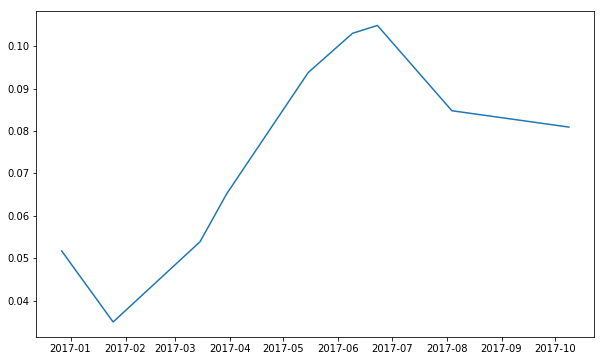

In [10]:
plt.figure(figsize=(10,6))
plt.plot(df['Str_Return'].cumsum())
plt.show()